In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import random
import nltk
from nltk import sent_tokenize, word_tokenize, PorterStemmer
from nltk.corpus import stopwords
import re
from sklearn.naive_bayes import MultinomialNB 
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [141]:
!pip install wordcloud
!pip install termcolor

In [142]:
import warnings
warnings.filterwarnings('ignore')

In [143]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Data Inspection

In [144]:
df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [145]:

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [146]:

df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [147]:

features_with_nan=[features for features in df_train.columns if df_train[features].isnull().sum()>0]
features_with_nan

['keyword', 'location']

In [148]:
for feature in features_with_nan:
    print(feature,np.round(df_train[feature].isnull().mean()*100,4),"% missing value")

keyword 0.8013 % missing value
location 33.272 % missing value


In [149]:
def drop_missing(df):
    i=0
    for col in df:
        if (df[col].isnull().sum()/7613) >0.3:
            df.drop(col,axis=1,inplace=True)
            print('Column',col,'is dropped')
            i+=1
    if i == 0:
        print('No Column Dropped')

In [150]:
df_train.duplicated().sum()

0

# Target Analysis

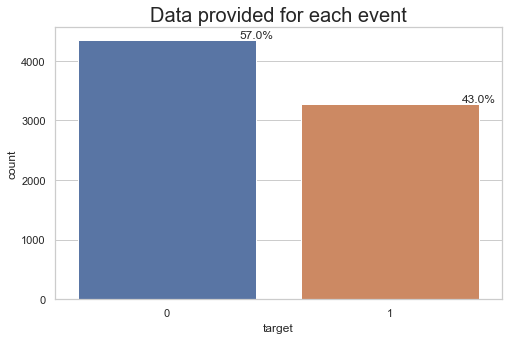

In [151]:
sns.set(style="whitegrid")
plt.figure(figsize=(8,5))
total = float(len(df_train))
ax = sns.countplot(x="target", data=df_train)
plt.title('Data provided for each event', fontsize=20)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()
    y = p.get_height()
    ax.annotate(percentage, (x,y+30),ha='center')
plt.show()

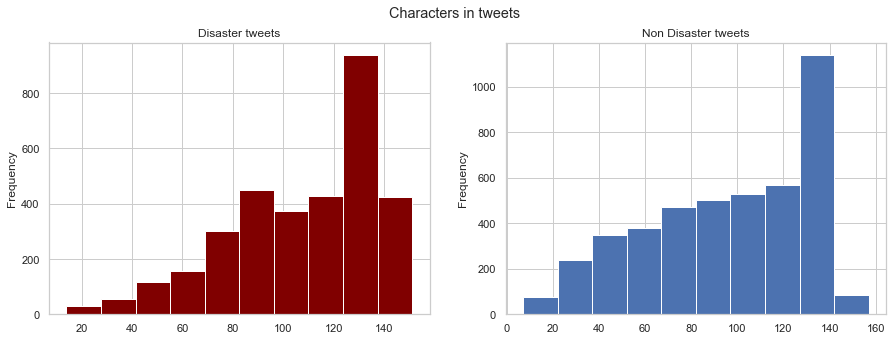

In [152]:
# 2 tweet length across both categories (no of chars)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df_train.query("target==1")["text"].str.len().plot(kind="hist",color="maroon",title="Disaster tweets");
plt.subplot(1, 2, 2)
df_train.query("target==0")["text"].str.len().plot(kind="hist",title="Non Disaster tweets");
plt.suptitle('Characters in tweets')
plt.show()

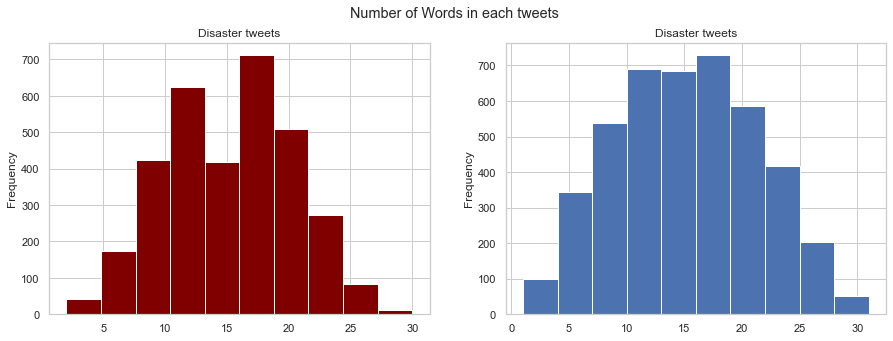

In [153]:
# 3 nmber of words in tweets in each category
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
df_train.query("target==1").text.map(lambda x: len(x.split())).plot(kind="hist",color="maroon",title="Disaster tweets");

plt.subplot(1, 2, 2)
df_train.query("target==0").text.map(lambda x: len(x.split())).plot(kind="hist",title="Disaster tweets");
plt.suptitle('Number of Words in each tweets')
plt.show()

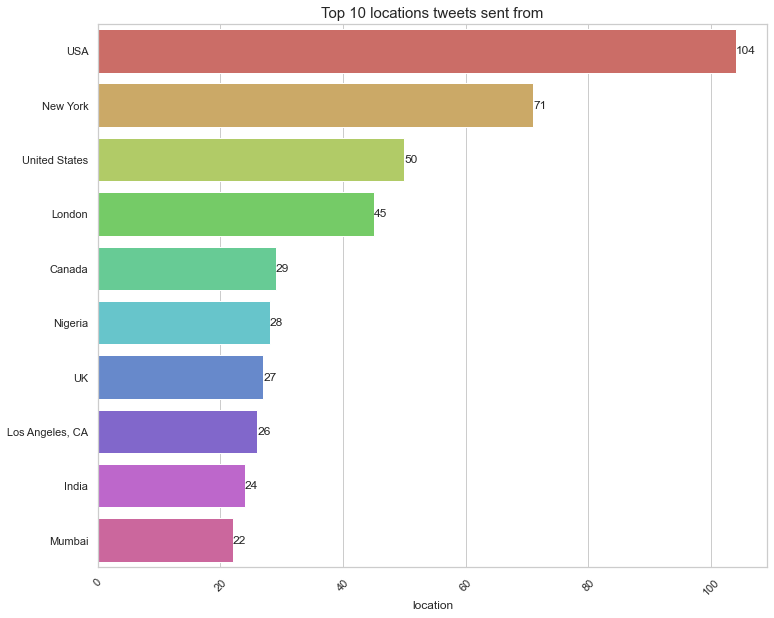

In [154]:
# 4 ad hoc - where tweets are coming from mostly
sns.set_style('whitegrid')
fig,axes = plt.subplots(figsize=(12,10))

locations = df_train["location"].value_counts()
ax = sns.barplot(y=locations[0:10].index,x=locations[0:10],palette='hls',data=df_train)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Top 10 locations tweets sent from',fontsize=15)
plt.xticks(rotation=45)
plt.show()


Word Cloud for Disaster Tweets


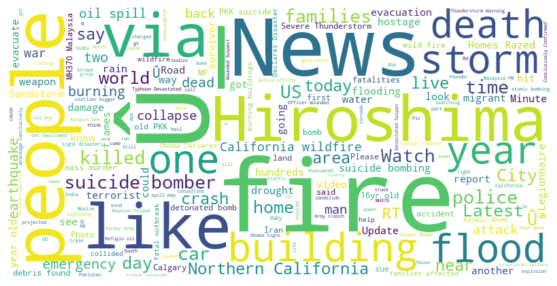


Word Cloud for Non-Disaster Tweets


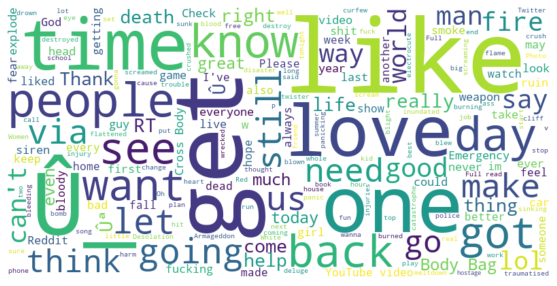

In [155]:
# 5 wordcloud
from wordcloud import STOPWORDS, WordCloud
from termcolor import colored
stop_words= set(stopwords.words("english"))

# updating the stopwords considering the 
stop_words.update(['https', 'http', 'amp', 'CO', 't', 'u', 'new', "I'm", "would"])

wc = WordCloud(width=800,height=400,max_words=200,stopwords=stop_words,max_font_size=150,background_color='white')

disaster_tweets_text = df_train.query("target==1").text
concat_disaster_tweets_text = disaster_tweets_text.str.cat(sep=" ")

non_disaster_tweets_text = df_train.query("target==0").text
concat_non_disaster_tweets_text = non_disaster_tweets_text.str.cat(sep=" ")

print("\nWord Cloud for Disaster Tweets")
wc.generate(concat_disaster_tweets_text)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

print("\nWord Cloud for Non-Disaster Tweets")
wc.generate(concat_non_disaster_tweets_text)
plt.figure(figsize=(12, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [156]:
## Removing the duplicate texts
df_train.drop_duplicates(subset=["text", "location", "target"], inplace=True)
print('There are {} rows and {} columns in train'.format(df_train.shape[0], df_train.shape[1]))

There are 7543 rows and 5 columns in train


In [157]:
#text = df_train['text']
#text=text.reset_index(drop=True)
df_train.reset_index(drop=True,inplace=True)

In [158]:

df_train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7538,10864,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7539,10866,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7540,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7541,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [159]:
def data_cleaning(text):
    # lower case
    text = text.lower()
    # Format regular expressions for data cleaning
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r"\W+", " ", text)
    # removing words with numbers
    text = re.sub('\w*\d\w*', '',text)

    # removing extra spaces
    text = re.sub('\s+', ' ', text).strip()
    # removing hashtags
    text = re.sub(r'#', '', text)
    # removing stock market tickers like $APPL
    re.sub(r'\$\w*', '', text)
    # removing stopwords
    text = text.split()
    stop = set(stopwords.words("english"))
    text = [w for w in text if not w in stop]
    text = " ".join(text)
    
    return text

def remove_links(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)


In [160]:
df_train['text'] = df_train['text'].apply(remove_links)
df_train['text'] = df_train['text'].apply(data_cleaning)

In [161]:
df_train['text']

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       people receive wildfires evacuation orders cal...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7538    flip side walmart bomb everyone evacuate stay ...
7539    suicide bomber kills saudi security site mosqu...
7540    two giant cranes holding bridge collapse nearb...
7541    police investigating e bike collided car littl...
7542    latest homes razed northern california wildfir...
Name: text, Length: 7543, dtype: object

In [162]:
def text_tokenization(text):
    lst_text = text.split()
    
    return lst_text

In [163]:
#TOKENIZATION
df_train['text'] = df_train['text'].apply(text_tokenization)

In [164]:
q=df_train['text']
wnl = nltk.WordNetLemmatizer()

In [165]:
#lemmitazation
relist= []
for w in df_train['text']:
    greg=[]
    for a in w:
        greg.append(wnl.lemmatize(a))
    relist.append(greg)
print(relist)

[['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u'], ['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada'], ['resident', 'asked', 'shelter', 'place', 'notified', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expected'], ['people', 'receive', 'wildfire', 'evacuation', 'order', 'california'], ['got', 'sent', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pours', 'school'], ['rockyfire', 'update', 'california', 'hwy', 'closed', 'direction', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfire'], ['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flooding', 'street', 'manitou', 'colorado', 'spring', 'area'], ['top', 'hill', 'see', 'fire', 'wood'], ['emergency', 'evacuation', 'happening', 'building', 'across', 'street'], ['afraid', 'tornado', 'coming', 'area'], ['three', 'people', 'died', 'heat', 'wave', 'far'], ['haha', 'south', 'tampa', 'getting', 'flooded', 'hah', 'wait', 'second', 'live', 'south', 'tampa', 'gonna', 'gonna', 'fvck', 'flooding'], ['ra

In [166]:
# save df_train in case we need it in the future

df_train2 = df_train

## TF-IDF Vectorization

In [167]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer=lambda x: x,
                        preprocessor=lambda x: x)
train_data_features = tfidf.fit_transform(df_train['text'])

print(train_data_features.shape)

(7543, 15723)


In [168]:

# We split train dataset
y_train = df_train['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_data_features, y_train, test_size=0.2, random_state=42)

## Naives Bayes

In [169]:
import sklearn.metrics as metrics

In [170]:
nb_classifier = MultinomialNB()
nb= nb_classifier.fit(X_train, y_train)
y_pred = nb.predict(X_test)
classification_report_test =metrics.classification_report(y_test, nb_classifier.predict(X_test))

print(classification_report_test)

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       878
           1       0.85      0.68      0.75       631

    accuracy                           0.81      1509
   macro avg       0.82      0.79      0.80      1509
weighted avg       0.82      0.81      0.81      1509



<AxesSubplot:>

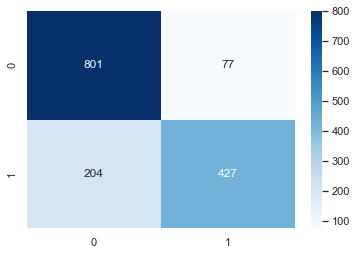

In [171]:
y_pred_test = nb.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

### Interpret

out of 888 not disaster tweets model predicted 801 tweets correctly.

out of 631 disaster tweets model predicted 427 tweets correctly.


## Random Forest

In [172]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
forest = RandomForestClassifier(random_state=42)
# Train model
forest = forest.fit(X_train, y_train)
#score
print(forest.score(X_test, y_test))

0.7886017229953611


<AxesSubplot:>

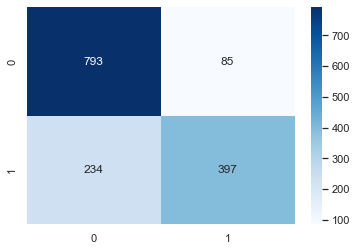

In [173]:
y_pred_test = forest.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

### Interpret

out of 888 not disaster tweets model predicted 793 tweets correctly.

out of 631 disaster tweets model predicted 397 tweets correctly.

In [174]:
# View the classification report for test data and predictions
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       878
           1       0.82      0.63      0.71       631

    accuracy                           0.79      1509
   macro avg       0.80      0.77      0.77      1509
weighted avg       0.79      0.79      0.78      1509



### Hyperparameter tuning

In [175]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

model_params = {
    'n_estimators': [130,230,500],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4],
}

forest = RandomForestClassifier()
rs = RandomizedSearchCV(forest, model_params, n_iter=100, cv=5, random_state=42)
# Train model
rs.fit(X_train, y_train)
#score
print('Best Score:', rs.best_score_)
print('Best Parameter', rs.best_params_)

Best Score: 0.7931720848945002
Best Parameter {'n_estimators': 130, 'min_samples_split': 10, 'min_samples_leaf': 4}


## Logistic Regression

In [176]:
from sklearn.linear_model import LogisticRegression

# Initialize a logistic regression model 
logistic = LogisticRegression(random_state=42)
# Train the model
logistic = logistic.fit(X_train, y_train)
# Print score of model(using test dataset)
print(logistic.score(X_test, y_test))

0.7919151756129887


In [177]:
y_pred_test = logistic.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84       878
           1       0.85      0.61      0.71       631

    accuracy                           0.79      1509
   macro avg       0.81      0.77      0.77      1509
weighted avg       0.80      0.79      0.78      1509



<AxesSubplot:>

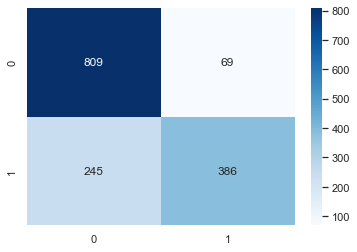

In [178]:
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

### hyper parameter tuning

In [179]:
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression(random_state=42)

parameters = [    
    {'penalty' : ['l2','none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

model = GridSearchCV(logistic, param_grid = parameters, cv = 3, verbose=True, n_jobs=-1)

best_clf = model.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


LogisticRegression(C=1.623776739188721, random_state=42)

In [180]:
print('Best Score:', best_clf.best_score_)
print('Best Parameter', best_clf.best_params_)

Best Score: 0.7916793948722715
Best Parameter {'C': 1.623776739188721, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


## KNN

In [181]:
from sklearn.neighbors import KNeighborsClassifier

#training the model
K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]
    
#Evaluating the model
for keys, values in scores.items():
    print(keys, ':', values)



2 : [0.8468677494199536, 0.7554671968190855]
3 : [0.8619489559164734, 0.7620941020543406]
4 : [0.8297978123964203, 0.7541418157720344]
5 : [0.8372555518727213, 0.7647448641484427]
6 : [0.8181968843221743, 0.7647448641484427]
7 : [0.8268147166058999, 0.7720344599072233]
8 : [0.8152137885316539, 0.777998674618953]
9 : [0.8176997016904209, 0.7793240556660039]
10 : [0.8067616837918462, 0.7833001988071571]
11 : [0.811070599933709, 0.781974817760106]
12 : [0.8059330460722572, 0.776673293571902]
13 : [0.8065959562479285, 0.7813121272365805]
14 : [0.8006297646668876, 0.780649436713055]
15 : [0.8016241299303944, 0.7773359840954275]
16 : [0.8004640371229699, 0.7793240556660039]
17 : [0.7993039443155452, 0.777998674618953]
18 : [0.7976466688763673, 0.7786613651424784]
19 : [0.7963208485250248, 0.7753479125248509]
20 : [0.7974809413324494, 0.7753479125248509]


In [182]:
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.76      0.89      0.82       878
           1       0.80      0.62      0.70       631

    accuracy                           0.78      1509
   macro avg       0.78      0.75      0.76      1509
weighted avg       0.78      0.78      0.77      1509



<AxesSubplot:>

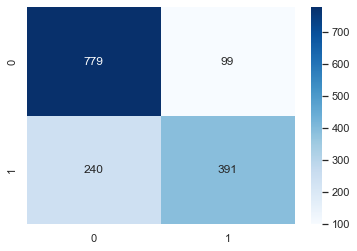

In [183]:
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

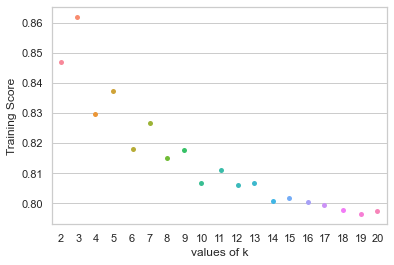

In [184]:
#Plotting the training and test scores graph
ax = sns.stripplot(K, training);
ax.set(xlabel ='values of k', ylabel ='Training Score')
plt.show()


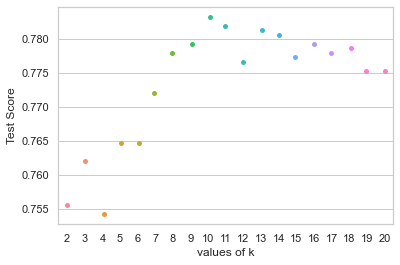

In [185]:


ax = sns.stripplot(K, test);
ax.set(xlabel ='values of k', ylabel ='Test Score')
plt.show()



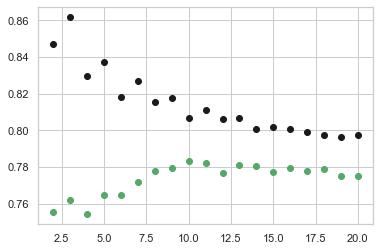

In [186]:

plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()


## Bag of words

In [187]:
from sklearn.feature_extraction.text import CountVectorizer
#https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/
 
vectorizer = CountVectorizer(tokenizer=lambda x: x,
                        preprocessor=lambda x: x)
bag = vectorizer.fit_transform(df_train['text'])
print(bag.shape)

(7543, 15723)


In [188]:
y_train.shape[0]

6034

In [189]:
bag.shape[0]

7543

In [190]:
# We split train dataset
y_train = df_train['target']

X_train, X_test, y_train, y_test = train_test_split(bag, y_train, test_size=0.2, random_state=42)

## Naives Bayes

In [191]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)
classification_report_test =metrics.classification_report(y_test, nb_classifier.predict(X_test))
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       878
           1       0.77      0.73      0.75       631

    accuracy                           0.80      1509
   macro avg       0.79      0.79      0.79      1509
weighted avg       0.80      0.80      0.80      1509



<AxesSubplot:>

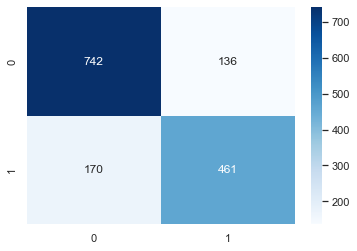

In [291]:
y_pred_test = nb_classifier.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

## Random Forest

In [193]:
from sklearn.ensemble import RandomForestClassifier
# Initialize Random Forest classifier
forest = RandomForestClassifier(random_state=42)
# Train model
forest = forest.fit(X_train, y_train)
#score
print(forest.score(X_test, y_test))

0.7813121272365805


<AxesSubplot:>

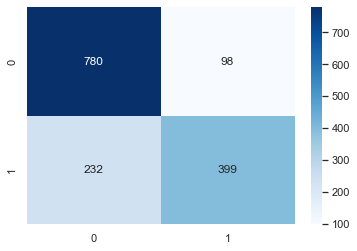

In [194]:
y_pred_test = forest.predict(X_test)
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

In [195]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

model_params = {
    'n_estimators': [130,230,500],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1, 2, 4],
}

forest = RandomForestClassifier()
rs = RandomizedSearchCV(forest, model_params, n_iter=100, cv=5, random_state=42)
# Train model
rs.fit(X_train, y_train)
#score
print('Best Score:', rs.best_score_)
print('Best Parameter', rs.best_params_)

Best Score: 0.7979773872971514
Best Parameter {'n_estimators': 230, 'min_samples_split': 2, 'min_samples_leaf': 2}


## Logistic Regression

In [196]:
from sklearn.linear_model import LogisticRegression

# Initialize a logistic regression model 
logistic = LogisticRegression(random_state=42)
# Train the model
logistic = logistic.fit(X_train, y_train)
# Print score of model(using test dataset)
print(logistic.score(X_test, y_test))

0.7939032471835653


In [197]:
y_pred_test = logistic.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       878
           1       0.80      0.68      0.73       631

    accuracy                           0.79      1509
   macro avg       0.79      0.78      0.78      1509
weighted avg       0.79      0.79      0.79      1509



<AxesSubplot:>

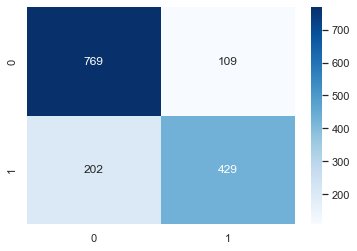

In [198]:
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

In [199]:
from sklearn.model_selection import GridSearchCV

logistic = LogisticRegression(random_state=42)

parameters = [    
    {'penalty' : ['l2','none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [100, 1000,2500, 5000]
    }
]

model = GridSearchCV(logistic, param_grid = parameters, cv = 3, verbose=True, n_jobs=-1)

best_clf = model.fit(X_train, y_train)

best_clf.best_estimator_

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


LogisticRegression(C=0.23357214690901212, max_iter=1000, random_state=42,
                   solver='saga')

In [200]:
print('Best Score:', best_clf.best_score_)
print('Best Parameter', best_clf.best_params_)

Best Score: 0.797315230117719
Best Parameter {'C': 0.23357214690901212, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}


## KNN

In [201]:
from sklearn.neighbors import KNeighborsClassifier

#training the model
K = []
training = []
test = []
scores = {}
  
for k in range(2, 21):
    clf = KNeighborsClassifier(n_neighbors = k)
    clf.fit(X_train, y_train)
  
    training_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    K.append(k)
  
    training.append(training_score)
    test.append(test_score)
    scores[k] = [training_score, test_score]
    
#Evaluating the model
for keys, values in scores.items():
    print(keys, ':', values)



2 : [0.7737819025522041, 0.7024519549370444]
3 : [0.8072588664235996, 0.711066931742876]
4 : [0.7364932051706994, 0.6918489065606361]
5 : [0.7500828637719589, 0.6931742876076872]
6 : [0.7028505137553861, 0.6679920477137177]
7 : [0.7127941663904541, 0.6779324055666004]
8 : [0.683128936029168, 0.6613651424784626]
9 : [0.6882664898906198, 0.6679920477137177]
10 : [0.6620815379516075, 0.6534128561961564]
11 : [0.665893271461717, 0.6560636182902585]
12 : [0.6516407026847862, 0.6474486414844268]
13 : [0.6531322505800464, 0.6507620941020543]
14 : [0.6441829632084852, 0.6414844267726971]
15 : [0.6465031488233345, 0.6441351888667992]
16 : [0.6387139542591979, 0.6375082836315441]
17 : [0.6392111368909513, 0.6375082836315441]
18 : [0.6286045740802121, 0.6269052352551359]
19 : [0.6309247596950613, 0.633532140490391]
20 : [0.6233012926748426, 0.6229290921139827]


In [202]:
y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       878
           1       0.98      0.10      0.18       631

    accuracy                           0.62      1509
   macro avg       0.80      0.55      0.47      1509
weighted avg       0.76      0.62      0.52      1509



<AxesSubplot:>

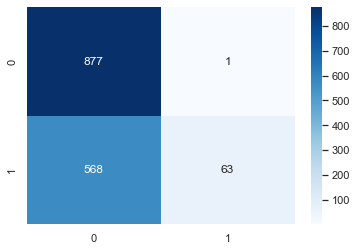

In [203]:
matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(matrix,annot=True,cmap='Blues', fmt='g')

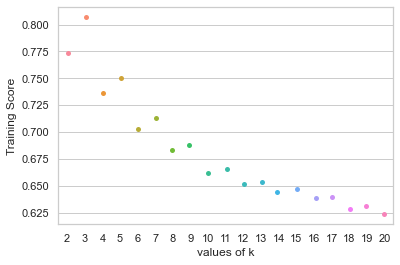

In [204]:
#Plotting the training and test scores graph
ax = sns.stripplot(K, training);
ax.set(xlabel ='values of k', ylabel ='Training Score')
plt.show()


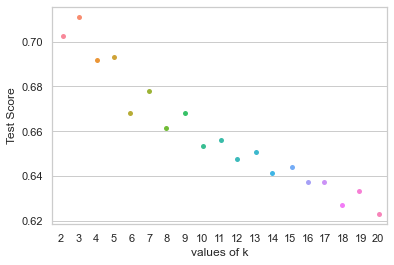

In [205]:


ax = sns.stripplot(K, test);
ax.set(xlabel ='values of k', ylabel ='Test Score')
plt.show()



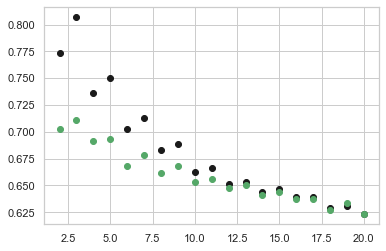

In [206]:

plt.scatter(K, training, color ='k')
plt.scatter(K, test, color ='g')
plt.show()


### Can Boosting Models improve performance?

### XGBoost Classifier

Since word of bags & TF-IDF didn't show significant difference we decided to use word of bags

In this section we focused on the best accuracy rate for the implication purpose

In [241]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier


from sklearn.feature_extraction.text import CountVectorizer
#https://vitalflux.com/text-classification-bag-of-words-model-python-sklearn/
 
vectorizer = CountVectorizer(tokenizer=lambda x: x,
                        preprocessor=lambda x: x)
bag = vectorizer.fit_transform(df_train['text'])
print(bag.shape)

(7543, 15723)


In [242]:
# We split train dataset
y_train = df_train['target']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bag, y_train, test_size=0.2, random_state=42)

In [249]:
xgbc = xgb.XGBClassifier(
        booster='gbtree',
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc'
    )

xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=80, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [250]:
y_pred = xgbc.predict(X_test)
classification_report_test =metrics.classification_report(y_test, xgbc.predict(X_test))
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.71      0.92      0.81       878
           1       0.82      0.48      0.61       631

    accuracy                           0.74      1509
   macro avg       0.77      0.70      0.71      1509
weighted avg       0.76      0.74      0.72      1509



In [251]:
xgbc = xgb.XGBClassifier(
        booster='gbtree',
        learning_rate=0.1,
        max_depth=7,
        n_estimators=300,
        use_label_encoder=False,
        eval_metric='auc'
    )

xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=7, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=300,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [252]:
y_pred = xgbc.predict(X_test)
classification_report_test =metrics.classification_report(y_test, xgbc.predict(X_test))
print(classification_report_test)

              precision    recall  f1-score   support

           0       0.76      0.90      0.83       878
           1       0.82      0.61      0.70       631

    accuracy                           0.78      1509
   macro avg       0.79      0.75      0.76      1509
weighted avg       0.78      0.78      0.77      1509



In [259]:
from sklearn.model_selection import StratifiedKFold

Kfold = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)

In [261]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

xgb = XGBClassifier(booster='gbtree', objective='binary:logistic',random_state=42, verbosity=0, use_label_encoder=False)

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [265]:
def grid_search(params, random=False): 

    xgb = XGBClassifier(booster='gbtree', objective='binary:logistic', 
                        random_state=2, verbosity=0, use_label_encoder=False)
    
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    if random:
        grid = RandomizedSearchCV(xgb, params, cv=kfold, n_iter=20, 
                                  n_jobs=-1, random_state=42)
    else:
        grid = GridSearchCV(xgb, params, cv=kfold, n_jobs=-1)
    

    grid.fit(X_train, y_train)


    best_params = grid.best_params_

    print("Parameters:", best_params)

    best_score = grid.best_score_

    print("Best Score: {:.5f}".format(best_score))

## XGBoost Hyperparameter Tuning

In [266]:
grid_search(params={'n_estimators':[100, 200, 400, 800]})

Parameters: {'n_estimators': 200}
Best Score: 0.78820


In [267]:
grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]})
  

Parameters: {'learning_rate': 0.5}
Best Score: 0.78571


In [268]:

grid_search(params={'max_depth':[2, 3, 5, 6, 8]})

Parameters: {'max_depth': 8}
Best Score: 0.78654


In [269]:

grid_search(params={'gamma':[0, 0.01, 0.1, 0.5, 1, 2]})

Parameters: {'gamma': 0.1}
Best Score: 0.78571


In [270]:

grid_search(params={'min_child_weight':[1, 2, 3, 4, 5]})

Parameters: {'min_child_weight': 1}
Best Score: 0.78074


In [271]:

grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Parameters: {'subsample': 0.9}
Best Score: 0.78273


In [272]:

grid_search(params={'subsample':[0.5, 0.7, 0.8, 0.9, 1]})

Parameters: {'subsample': 0.9}
Best Score: 0.78273


## Adjust

In [273]:
grid_search(params={'n_estimators':[2, 25, 50, 75, 100, 200,250]})

Parameters: {'n_estimators': 200}
Best Score: 0.78820


In [274]:

grid_search(params={'max_depth':[1, 2, 3, 4, 6, 7, 8, 9,10], 
                    'n_estimators':[200]})

Parameters: {'max_depth': 6, 'n_estimators': 200}
Best Score: 0.78820


In [276]:

grid_search(params={'learning_rate':[0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7], 
                    'max_depth':[6], 'n_estimators':[200]})

Parameters: {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
Best Score: 0.78820


In [279]:

grid_search(params={'colsample_bytree':[0.5, 0.6, 0.7, 0.8, 0.9, 1],
                    'learning_rate':[0.3], 
                    'max_depth':[6], 'n_estimators':[200]})

Parameters: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 200}
Best Score: 0.78820
